<a id="Section_Title"></a>
# ** Data Analysis of the Boston Marathon Finishers by Gender**

The objective of this analysis is to develop a model to determine whether a patiente will show up to an appointment or not based on information about the patient demographics, clinical details as well as information about the appointment. 
The following is the roadmap of the study:
1. [Data Assessment](#section_DataAssesment)
2. [Data Exploration](#section_DataExploration)
3. [Predictive Models](#section_PredictiveModels)
> * [Random Forest](#section_RandomForest)
> * [Gradient Boost](#section_GradientBoost)
> * [XGBoost](#section_XGBoost)
> * [XGBoost - Grid Search Optimization](#section_XGBoost_Optimization)
4. [Results](#section_Results)
5. [Conclusion and Next Steps](#section_Conclusion)

<a id="section_DataAssesment"></a>
## **Data Assessment** 

In [1]:
# Importing relevant libraries 
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)
import pandas as pd
import numpy as np
import scipy.stats
import pylab as plt
from matplotlib.colors import LogNorm

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

In [2]:
data = pd.read_csv('../input/noshowappointments/KaggleV2-May-2016.csv',dtype={'PatientId': object})

In [3]:
data.head(10)

,PatientId,AppointmentID,Gender,DataMarcacaoConsulta,DataAgendamento,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,95985133231274,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
6,733688164476661,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3449833394123,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,56394729949972,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No
9,78124564369297,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No


### Generalities of the data set
Data Dictionary
* PatientId: Identification Number of the patient - string
* AppointmentID: Identification Number of Appointment - string
* Gender: Gender of Patient - string: format {M,F}
* DateOfAppointment: Date when the appointment takes place - string:format YYYY-MM-DD T HH:mm:ssZ
* DateOfSchedule: Date when the appointment was scheduled - string:format YYYY-MM-DD T HH:mm:ssZ
* Age: Age of Patient - integer
* Neighborhood: Neighborhood of patient address - string
* Scholarship: whether the patient received external aid - binary
* Hypertension: whether the patient presents hypertension - binary
* Diabetes: whether the patient presents diabetes - binary
* Alchoholism: whether the patient presents alchoholism - binary
* Handicap: whether the patient presents any kind of handicap - binary
* SMS: whether the patient received a SMS - binary
* No-Show: Whether the patient showed up (yes) or not (no) - string: format {Yes,No}

In [4]:
print('Number of items in data set',data.shape[0])
print('Number of unique patients', len(np.unique(data['PatientId'])))
print('Number of unique appointments', len(np.unique(data['AppointmentID'])),'same as number of datasets')
print('Gender Values:', np.unique(data['Gender']))
print('Gender distribution: Male', len(data[data['Gender']=='M']), 'Female', len(data[data['Gender']=='F']))
print('Age Values: Min',data['Age'].min(), 'Max', data['Age'].max())
print('Neighborhood Values:', len(np.unique(data['Neighbourhood'])))

Number of items in data set 110527
Number of unique patients 62299
Number of unique appointments 110527 same as number of datasets
Gender Values: ['F' 'M']
Gender distribution: Male 38687 Female 71840
Age Values: Min -1 Max 115
Neighborhood Values: 81


### Cleaning the Data - Selecting useful Columns and transforming categorical Columns

In [5]:
data['AD_year'] = pd.to_datetime(data['DataAgendamento']).dt.year
data['AD_month'] = pd.to_datetime(data['DataAgendamento']).dt.month
data['AD_week'] = pd.to_datetime(data['DataAgendamento']).dt.week
data['AD_dow'] = pd.to_datetime(data['DataAgendamento']).dt.dayofweek
data['AD_hour'] = pd.to_datetime(data['DataAgendamento']).dt.hour
data['AD_min'] = pd.to_datetime(data['DataAgendamento']).dt.minute

data['SD_year'] = pd.to_datetime(data['DataMarcacaoConsulta']).dt.year
data['SD_month'] = pd.to_datetime(data['DataMarcacaoConsulta']).dt.month
data['SD_week'] = pd.to_datetime(data['DataMarcacaoConsulta']).dt.week
data['SD_dow'] = pd.to_datetime(data['DataMarcacaoConsulta']).dt.dayofweek
data['SD_hour'] = pd.to_datetime(data['DataMarcacaoConsulta']).dt.hour
data['SD_min'] = pd.to_datetime(data['DataMarcacaoConsulta']).dt.minute

data['AD_SD'] = (pd.to_datetime(data['DataAgendamento'])-pd.to_datetime(data['DataMarcacaoConsulta']))/np.timedelta64(1, 'D')

In [6]:
data['Gender'] = pd.Categorical(data['Gender'])
data['GenderB'] = data['Gender'].cat.codes
dGENDER = dict(enumerate(data['Gender'].cat.categories))

In [7]:
data['Neighbourhood'] = pd.Categorical(data['Neighbourhood'])
data['NeighborhoodC'] = data['Neighbourhood'].cat.codes
dNEIGHBORHOOD = dict(enumerate(data['Neighbourhood'].cat.categories))

In [8]:
data['No-show'] = pd.Categorical(data['No-show'])
data['StatusB'] = data['No-show'].cat.codes
dSTATUS = dict(enumerate(data['No-show'].cat.categories))

In [9]:
data.head()

,PatientId,AppointmentID,Gender,DataMarcacaoConsulta,DataAgendamento,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,SD_year,SD_month,SD_week,SD_dow,SD_hour,SD_min,AD_SD,GenderB,NeighborhoodC,StatusB
0,29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,...,2016,4,17,4,18,38,-0.776481,0,39,0
1,558997776694438,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,...,2016,4,17,4,16,8,-0.672535,1,39,0
2,4262962299951,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,...,2016,4,17,4,16,19,-0.679907,0,45,0
3,867951213174,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,...,2016,4,17,4,17,29,-0.728831,0,54,0
4,8841186448183,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,...,2016,4,17,4,16,7,-0.671794,0,39,0


[Top](#Section_Title)

<a id="section_DataExploration"></a>
## **Data Exploration**

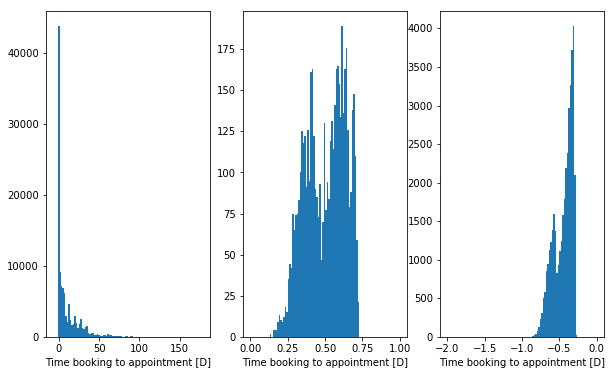

In [10]:
fig, ax = plt.subplots(ncols=3)
ax[0].hist(data['AD_SD'],bins=100)
ax[0].set_xlabel('Time booking to appointment [D]')
ax[1].hist(data['AD_SD'],bins=100, range=(0,1))
ax[1].set_xlabel('Time booking to appointment [D]')
ax[2].hist(data['AD_SD'],bins=100, range=(-2,0))
ax[2].set_xlabel('Time booking to appointment [D]')
plt.show()

[Top](#Section_Title)

<a id="section_PredictiveModels"></a>
## **Predictive Models**

In [11]:
data.columns.values

array(['PatientId', 'AppointmentID', 'Gender', 'DataMarcacaoConsulta',
       'DataAgendamento', 'Age', 'Neighbourhood', 'Scholarship',
       'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received',
       'No-show', 'AD_year', 'AD_month', 'AD_week', 'AD_dow', 'AD_hour',
       'AD_min', 'SD_year', 'SD_month', 'SD_week', 'SD_dow', 'SD_hour',
       'SD_min', 'AD_SD', 'GenderB', 'NeighborhoodC', 'StatusB'], dtype=object)

In [12]:
features = [ 'Age', 'Scholarship',
       'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received',
        'AD_year', 'AD_month', 'AD_week', 'AD_dow', 'AD_hour',
       'AD_min', 'SD_year', 'SD_month', 'SD_week', 'SD_dow', 'SD_hour',
       'SD_min', 'AD_SD', 'GenderB', 'NeighborhoodC']

In [13]:
N_SAMPLE = 10000
X = data[features][:N_SAMPLE]
y = data['StatusB'][:N_SAMPLE]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

<a id="section_RandomForest"></a>
### Random Forest

In [15]:
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train,y_train)
y_pred_rf = rfc.predict(X_test)
y_score_rf = rfc.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
print('Random Forest ROC AUC', auc(fpr_rf, tpr_rf))
print(classification_report(y_test, y_pred_rf, target_names=['NoShow','ShowUp']))

Random Forest ROC AUC 0.739425588478
             precision    recall  f1-score   support

     NoShow       0.81      0.98      0.89      2606
     ShowUp       0.62      0.12      0.20       694

avg / total       0.77      0.80      0.74      3300



<a id="section_GradientBoosting"></a>
### Gradient Boosting

In [16]:
gbc = GradientBoostingClassifier(n_estimators=1000)
gbc.fit(X_train,y_train)
y_pred_gb = gbc.predict(X_test)
y_score_gb = gbc.predict_proba(X_test)[:,1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_score_gb)
print('Gradient Boosting ROC AUC', auc(fpr_gb, tpr_gb))
print(classification_report(y_test, y_pred_gb, target_names=['NoShow','ShowUp']))

Gradient Boosting ROC AUC 0.73348136975
             precision    recall  f1-score   support

     NoShow       0.81      0.94      0.87      2606
     ShowUp       0.43      0.17      0.25       694

avg / total       0.73      0.78      0.74      3300



<a id="section_XGBoost"></a>
### XGBoost

In [17]:
xgbc = xgb.XGBClassifier()
xgbc.fit(X_train, y_train)
y_pred_xgb = xgbc.predict(X_test)
y_score_xgb = xgbc.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
print('XGBoost ROC AUC', auc(fpr_xgb, tpr_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=['NoShow','ShowUp']))

XGBoost ROC AUC 0.736919456541
             precision    recall  f1-score   support

     NoShow       0.79      0.99      0.88      2606
     ShowUp       0.51      0.03      0.06       694

avg / total       0.73      0.79      0.71      3300



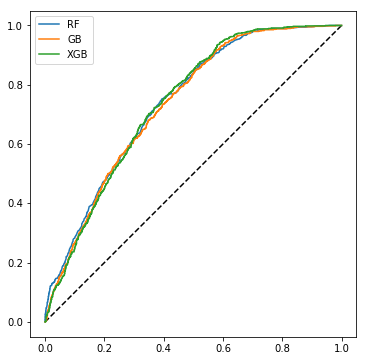

In [18]:
fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gb, tpr_gb, label='GB')
plt.plot(fpr_xgb, tpr_xgb, label='XGB')
ax.set_aspect('equal')
plt.legend()
plt.show()

<a id="section_XGBoost_Optimization"></a>
### XGBoost - Grid Search Optimization

In [19]:
model = xgb.XGBClassifier(max_depth=3, n_estimators=400, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred_xgb = model.predict(X_test)
y_score_xgb = model.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
print('XGBoost ROC AUC', auc(fpr_xgb, tpr_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=['NoShow','ShowUp']))

XGBoost ROC AUC 0.738373648928
             precision    recall  f1-score   support

     NoShow       0.80      0.97      0.88      2606
     ShowUp       0.49      0.10      0.17       694

avg / total       0.74      0.79      0.73      3300



In [20]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 100, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_model = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 
optimized_model.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [21]:
best_optimized_model = optimized_model.best_estimator_

In [22]:
y_pred_xgb = optimized_model.predict(X_test)
y_score_xgb = optimized_model.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
print('XGBoost ROC AUC', auc(fpr_xgb, tpr_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=['NoShow','ShowUp']))

XGBoost ROC AUC 0.740811494644
             precision    recall  f1-score   support

     NoShow       0.79      0.99      0.88      2606
     ShowUp       0.38      0.02      0.04       694

avg / total       0.71      0.79      0.70      3300



[Top](#Section_Title)

<a id="section_Results"></a>
## **Results**
The three predictive methods explored showed very similar performances. Given the complexity of the problem and the relatively small number of feauters in the data, specially demographic data, the results are very accurate. 

In [23]:
i_index = 2
def getAUC_XGB(i_index):
    slFIELDS = features[:i_index] + features[i_index+1:]
    X = data[slFIELDS]
    y = data['StatusB']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    xgbc_best = best_optimized_model
    xgbc_best.fit(X_train, y_train)
    y_pred_xgb = xgbc_best.predict(X_test)
    y_score_xgb = xgbc_best.predict_proba(X_test)[:,1]
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
    return auc(fpr_xgb, tpr_xgb)

In [24]:
lAUC = []
lIND = []
for ii in range(len(features)):
    lIND.append(features[ii])
    lAUC.append(getAUC_XGB(ii))

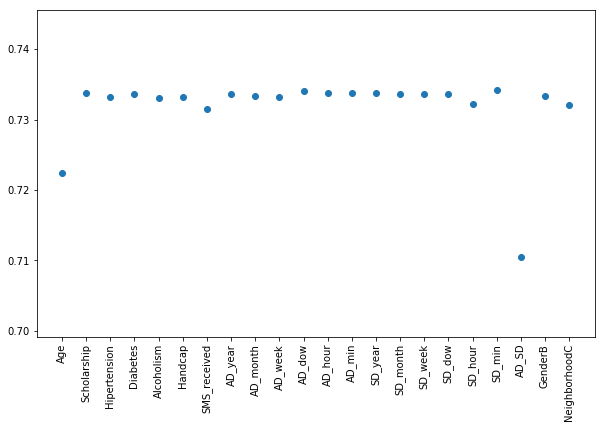

In [28]:
plt.scatter(range(len(lIND)),lAUC)
plt.xticks([ii for ii in range(len(features))], features, rotation='vertical')
plt.show()

In [30]:
data_scores = pd.DataFrame({'Feature':lIND, 'Scores':lAUC })
data_scores.sort_values('Scores').head()

,Feature,Scores
19,AD_SD,0.710474
0,Age,0.722378
6,SMS_received,0.731535
21,NeighborhoodC,0.731991
17,SD_hour,0.732141


It's clear from the plot that the two features that affect the most our model if we do not include them are AD_SD (the time between scheduleing the the appointment and the actual date of the appointment) and the age of the patient. The next features taht affect the outcome of the predictor are whether the patient received a SMS prior to the appointment, the neighborhood of the patient's address.

[Top](#Section_Title)

<a id="section_Conclusion"></a>
## **Conclusion and Next Steps**
The analysis of the show/no-show patterns for a dataset of medical appointment was presented. 
The three machine learning explored produced good results. The top factors that affected the XGBoost arethe 
time between the scheduling of the appointment and the appointment, the age of the patient, whether the patient
received an SMS prior to the appointment and the patients neighborhood.

In order to improve the rate of show-up, its then possible to alert patients that have a long time
from schedule-to-appointment as well as the age.
[Top](#Section_Title)